In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.optimize import curve_fit
from sympy import symbols, diff, lambdify
import os
from matplotlib.ticker import FuncFormatter

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Format numbers with thousand separators and Swiss Francs
def chf_formatter(x, pos):
    return f'CHF {int(x):,}'.replace(',', "'")

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Load the data from the JSON files
# Update these paths to match your file locations

# Load room count data
with open('../../data/processed/swiss_rental_data_m2_room_count/Durchscnittlicher_Mietpreis_m2_Zimmerzahl_Kanton_combined.json', 'r', encoding='utf-8') as f:
    room_data = json.load(f)

# Load construction period data
with open('../../data/processed/swiss_rental_data_m2_construction_period/Durchschnittlicher_Mietpreis_m2_Bauperiode_Kanton_combined.json', 'r', encoding='utf-8') as f:
    construction_data = json.load(f)

print(f"Loaded data for rooms: {len(room_data)} entries")
print(f"Loaded data for construction periods: {len(construction_data)} entries")

Loaded data for rooms: 324 entries
Loaded data for construction periods: 324 entries


In [4]:
# Function to convert nested JSON to a flat DataFrame
def flatten_room_data(json_data):
    flat_data = {
        "year": [],
        "canton": [],
        "room_count": [],
        "avg_price_per_sqm": [],
        "confidence_interval": []
    }
    
    for item in json_data:
        for room in item.get("room_categories", []):
            flat_data["year"].append(item.get("year"))
            flat_data["canton"].append(item.get("canton"))
            flat_data["room_count"].append(room.get("room_count"))
            flat_data["avg_price_per_sqm"].append(room.get("avg_price_per_sqm"))
            flat_data["confidence_interval"].append(room.get("confidence_interval"))
    
    return pd.DataFrame(flat_data)

def flatten_construction_data(json_data):
    flat_data = {
        "year": [],
        "canton": [],
        "construction_period": [],
        "avg_price_per_sqm": [],
        "confidence_interval": []
    }
    
    for item in json_data:
        for period in item.get("construction_periods", []):
            flat_data["year"].append(item.get("year"))
            flat_data["canton"].append(item.get("canton"))
            flat_data["construction_period"].append(period.get("construction_period"))
            flat_data["avg_price_per_sqm"].append(period.get("avg_price_per_sqm"))
            flat_data["confidence_interval"].append(period.get("confidence_interval"))
    
    return pd.DataFrame(flat_data)

In [5]:
# Convert JSON data to DataFrames
room_df = flatten_room_data(room_data)
construction_df = flatten_construction_data(construction_data)

# Convert year to numeric where possible
room_df['year'] = pd.to_numeric(room_df['year'], errors='ignore')
construction_df['year'] = pd.to_numeric(construction_df['year'], errors='ignore')

# Clean room count to numeric values (remove '+' symbols)
room_df['room_count_num'] = room_df['room_count'].apply(
    lambda x: float(str(x).replace('+', '')) if pd.notna(x) else np.nan
)

# Display basic information about the datasets
print("Room count dataset summary:")
print(f"Years included: {sorted(room_df['year'].unique())}")
print(f"Number of cantons: {room_df['canton'].nunique()}")
print(f"Room categories: {sorted(room_df['room_count'].unique())}")
print(f"Total data points: {len(room_df)}")
print("\n")

print("Construction period dataset summary:")
print(f"Years included: {sorted(construction_df['year'].unique())}")
print(f"Number of cantons: {construction_df['canton'].nunique()}")
print(f"Construction periods: {sorted(construction_df['construction_period'].unique())}")
print(f"Total data points: {len(construction_df)}")

Room count dataset summary:
Years included: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Number of cantons: 27
Room categories: ['1', '2', '3', '4', '5', '6+']
Total data points: 1930


Construction period dataset summary:
Years included: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Number of cantons: 27
Construction periods: ['1919 - 1945', '1946 - 1960', '1961 - 1970', '1971 - 1980', '1981 - 1990', '1991 - 2000', '2001-2010', '2001-2012', '2001-2013', '2011-2014', '2011-2015', '2011-2016', '2011-2017', '2011-2018', '2011-2019', '2011-2020', '2011-2021', '2011-2022', '2021-2023', 'Total', 'Vor 1919']
Total data points: 3201


C:\Users\Nevin\AppData\Local\Temp\ipykernel_36112\2485111857.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  room_df['year'] = pd.to_numeric(room_df['year'], errors='ignore')
C:\Users\Nevin\AppData\Local\Temp\ipykernel_36112\2485111857.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  construction_df['year'] = pd.to_numeric(construction_df['year'], errors='ignore')


In [6]:
# Basic statistics for both datasets
print("Summary statistics for room count dataset (price per m²):")
display(room_df['avg_price_per_sqm'].describe())

print("\nSummary statistics for construction period dataset (price per m²):")
display(construction_df['avg_price_per_sqm'].describe())

# Use the most recent year for analysis
latest_room_year = max(room_df['year'])
latest_construction_year = max(construction_df['year'])

print(f"\nUsing data from year {latest_room_year} for room analysis")
print(f"Using data from year {latest_construction_year} for construction period analysis")

# Filter for the latest year
room_latest = room_df[room_df['year'] == latest_room_year]
construction_latest = construction_df[construction_df['year'] == latest_construction_year]

Summary statistics for room count dataset (price per m²):


count    1930.000000
mean       15.427202
std         2.849014
min         7.100000
25%        13.400000
50%        14.900000
75%        17.200000
max        27.400000
Name: avg_price_per_sqm, dtype: float64


Summary statistics for construction period dataset (price per m²):


count    3201.000000
mean       15.288691
std         2.490907
min         9.400000
25%        13.500000
50%        14.800000
75%        16.800000
max        27.300000
Name: avg_price_per_sqm, dtype: float64


Using data from year 2023 for room analysis
Using data from year 2023 for construction period analysis


C:\Users\Nevin\AppData\Local\Temp\ipykernel_36112\3412649313.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='room_count', y='avg_price_per_sqm',


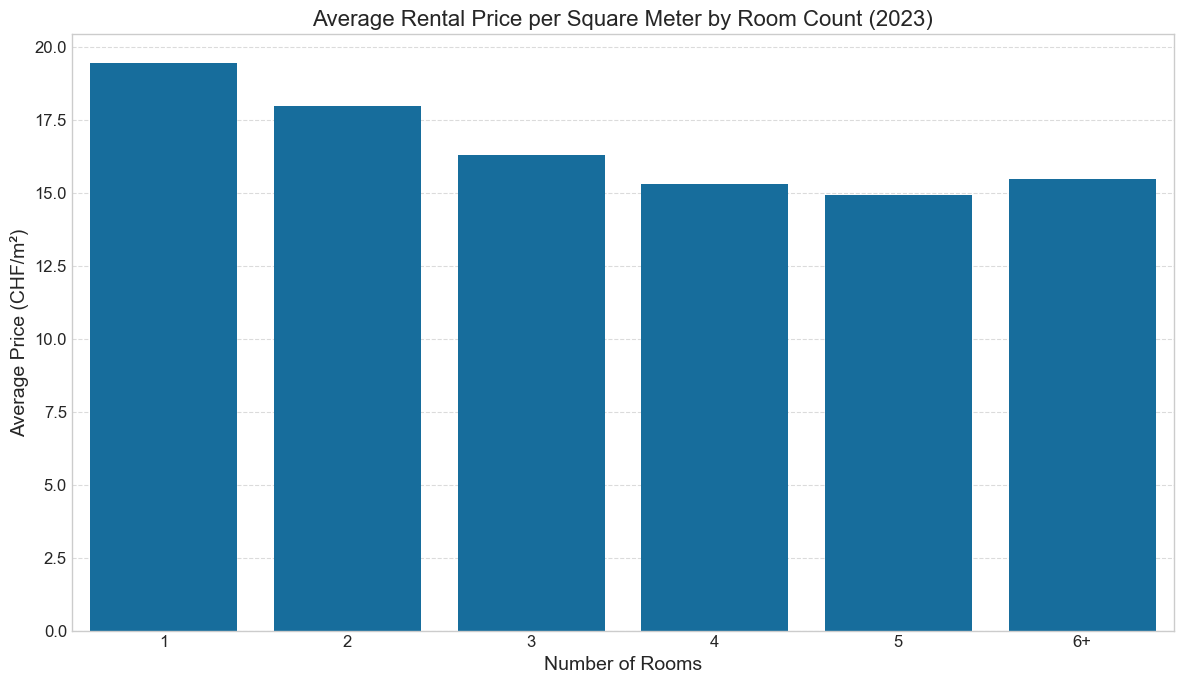

Correlation between number of rooms and price per m²: -0.9007


In [7]:
# Visualize the relationship between room count and price per m²
plt.figure(figsize=(12, 7))

# Order room categories
room_order = sorted(room_latest['room_count'].unique(), 
                   key=lambda x: float(str(x).replace('+', '')) if str(x).replace('+', '').isdigit() else 999)

# Create the bar plot
sns.barplot(x='room_count', y='avg_price_per_sqm', 
            data=room_latest, 
            order=room_order,
            ci=None)

plt.title(f'Average Rental Price per Square Meter by Room Count ({latest_room_year})', fontsize=16)
plt.xlabel('Number of Rooms', fontsize=14)
plt.ylabel('Average Price (CHF/m²)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate correlation
room_avg = room_latest.groupby('room_count_num')['avg_price_per_sqm'].mean().reset_index()
room_corr = room_avg['room_count_num'].corr(room_avg['avg_price_per_sqm'])
print(f"Correlation between number of rooms and price per m²: {room_corr:.4f}")

C:\Users\Nevin\AppData\Local\Temp\ipykernel_36112\3260247867.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='construction_period', y='avg_price_per_sqm',


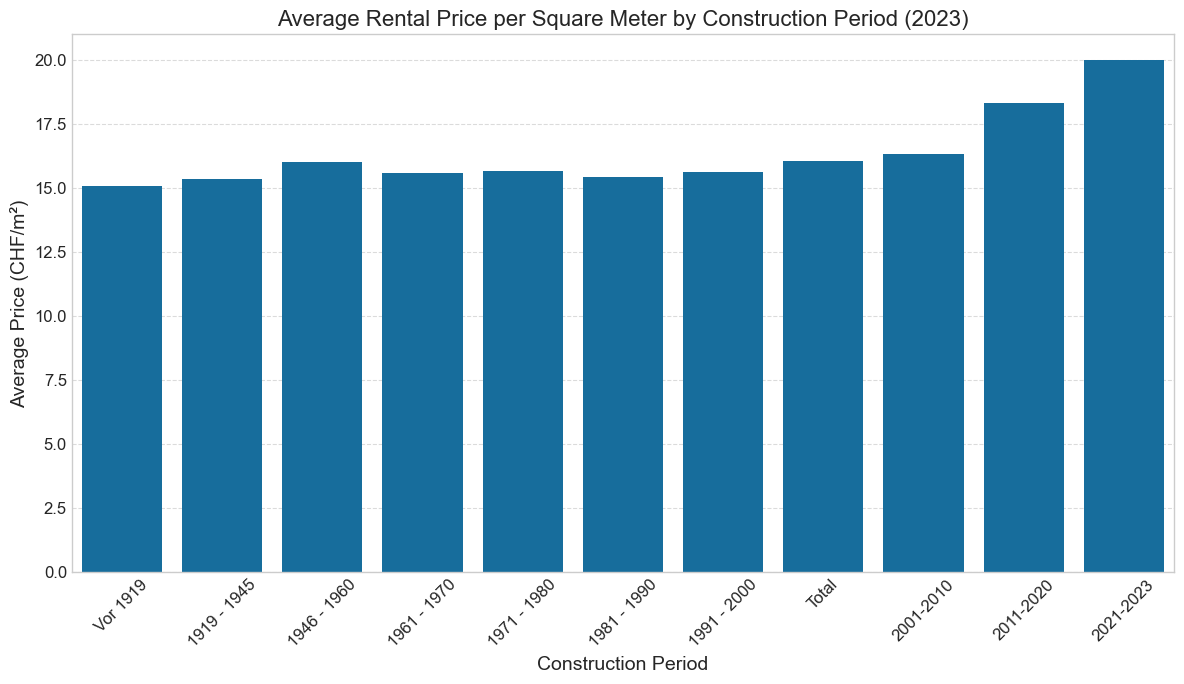

Modern construction periods: ['2001-2010', '2011-2020']
Old construction periods: ['Vor 1919', '1919 - 1945', '1946 - 1960']
Average price for modern buildings: CHF 17.32 per m²
Average price for old buildings: CHF 15.46 per m²
Price difference: CHF 1.85 per m² (12.0%)


In [8]:
# Visualize the relationship between construction period and price per m²
plt.figure(figsize=(12, 7))

# Order construction periods (trying to maintain chronological order)
period_order = sorted(construction_latest['construction_period'].unique(), 
                     key=lambda x: int(x.split('-')[0]) if '-' in x else 
                     (1900 if 'vor' in x.lower() else 
                      (2100 if 'nach' in x.lower() or 'ab' in x.lower() else 2000)))

# Create the bar plot
sns.barplot(x='construction_period', y='avg_price_per_sqm', 
            data=construction_latest, 
            order=period_order,
            ci=None)

plt.title(f'Average Rental Price per Square Meter by Construction Period ({latest_construction_year})', fontsize=16)
plt.xlabel('Construction Period', fontsize=14)
plt.ylabel('Average Price (CHF/m²)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Identify modern vs. older buildings (simplified categorization)
modern_periods = [p for p in period_order if any(x in p for x in ['2001', '2010', '2020', 'nach'])]
old_periods = [p for p in period_order if any(x in p for x in ['vor', '1919', '1945', '1960'])]

print("Modern construction periods:", modern_periods)
print("Old construction periods:", old_periods)

# Calculate average prices for modern vs. old buildings
if modern_periods and old_periods:
    modern_price = construction_latest[construction_latest['construction_period'].isin(modern_periods)]['avg_price_per_sqm'].mean()
    old_price = construction_latest[construction_latest['construction_period'].isin(old_periods)]['avg_price_per_sqm'].mean()
    
    print(f"Average price for modern buildings: CHF {modern_price:.2f} per m²")
    print(f"Average price for old buildings: CHF {old_price:.2f} per m²")
    print(f"Price difference: CHF {modern_price - old_price:.2f} per m² ({(modern_price/old_price - 1)*100:.1f}%)")

In [9]:
# PART 1: MODELING THE COST FUNCTION BY ROOM COUNT
# For this analysis, we need to estimate typical apartment sizes for each room count

# Define typical apartment sizes by room count (in m²)
# These are approximations based on common Swiss apartment sizes
typical_sizes = {
    '1': 35,   # 1-room apartment (studio): ~35m²
    '2': 55,   # 2-room apartment: ~55m²
    '3': 75,   # 3-room apartment: ~75m²
    '4': 95,   # 4-room apartment: ~95m²
    '5': 120,  # 5-room apartment: ~120m²
    '5+': 130, # 5+ room apartment: ~130m²
    '6': 150,  # 6-room apartment: ~150m²
    '6+': 160  # 6+ room apartment: ~160m²
}

# Create a dataset with apartment sizes and total costs
cost_data = []

# Calculate total costs based on price per m² and typical sizes
for room_group in room_latest.groupby('room_count'):
    room_count = room_group[0]
    avg_price = room_group[1]['avg_price_per_sqm'].mean()
    
    if room_count in typical_sizes:
        size = typical_sizes[room_count]
        total_rent = avg_price * size
        cost_data.append({
            'room_count': room_count,
            'room_count_num': float(str(room_count).replace('+', '')),
            'apartment_size': size,
            'price_per_sqm': avg_price,
            'total_monthly_rent': total_rent
        })

cost_df = pd.DataFrame(cost_data)
cost_df = cost_df.sort_values('apartment_size')

print("Estimated apartment sizes and monthly rents:")
display(cost_df)

Estimated apartment sizes and monthly rents:


,room_count,room_count_num,apartment_size,price_per_sqm,total_monthly_rent
0,1,1.0,35,19.442308,680.480769
1,2,2.0,55,17.970370,988.370370
2,3,3.0,75,16.270370,1220.277778
3,4,4.0,95,15.288889,1452.444444
4,5,5.0,120,14.914815,1789.777778
5,6+,6.0,160,15.459259,2473.481481


Fitted cost function parameters: a = 0.022083, b = 9.6461, c = 349.20


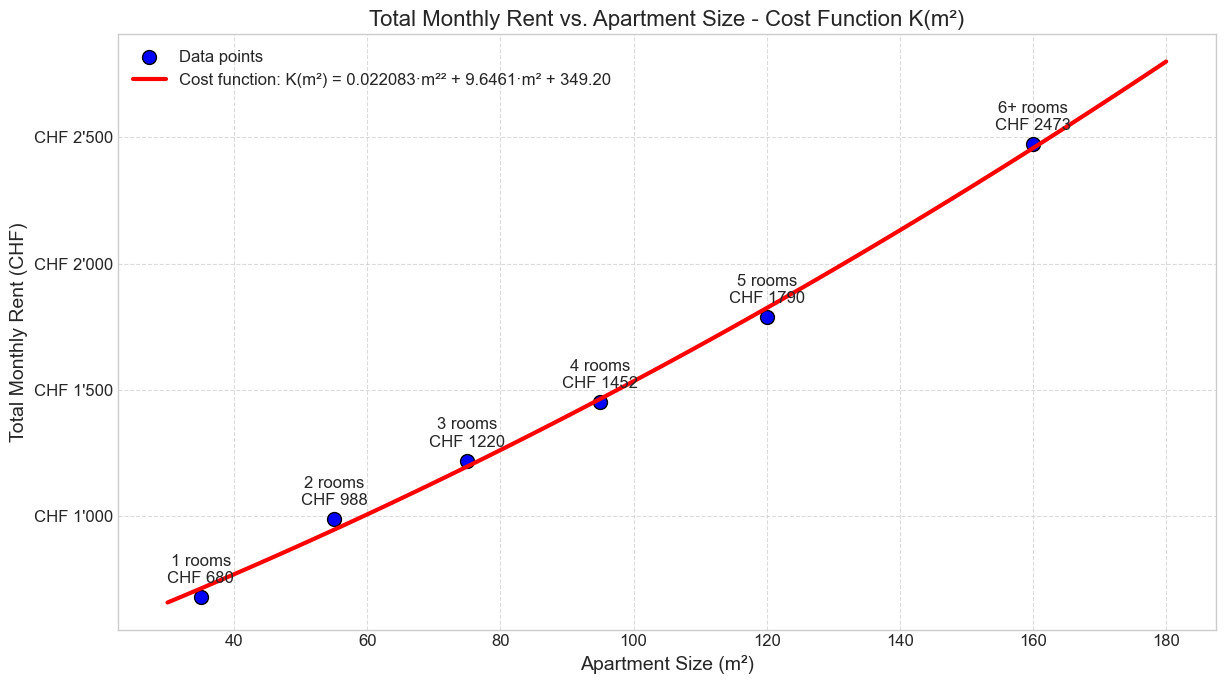

R² value for the cost function fit: 0.9975


In [10]:
# Plot the relationship between apartment size and total rent
plt.figure(figsize=(12, 7))

# Scatter plot of actual data points
plt.scatter(cost_df['apartment_size'], cost_df['total_monthly_rent'], 
            s=100, color='blue', edgecolor='black', label='Data points')

# Add labels for each data point
for i, row in cost_df.iterrows():
    plt.annotate(f"{row['room_count']} rooms\nCHF {row['total_monthly_rent']:.0f}", 
               (row['apartment_size'], row['total_monthly_rent']),
               textcoords="offset points", 
               xytext=(0, 10), 
               ha='center')

# Fit a polynomial curve to the data
# We'll use a quadratic function: y = ax² + bx + c
def cost_function(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the curve
params, covariance = curve_fit(cost_function, 
                              cost_df['apartment_size'], 
                              cost_df['total_monthly_rent'])

a, b, c = params
print(f"Fitted cost function parameters: a = {a:.6f}, b = {b:.4f}, c = {c:.2f}")

# Generate points for the curve
x_fit = np.linspace(min(cost_df['apartment_size']) - 5, max(cost_df['apartment_size']) + 20, 100)
y_fit = cost_function(x_fit, a, b, c)

# Plot the fitted curve
plt.plot(x_fit, y_fit, 'r-', linewidth=3, 
         label=f'Cost function: K(m²) = {a:.6f}·m²² + {b:.4f}·m² + {c:.2f}')

plt.title('Total Monthly Rent vs. Apartment Size - Cost Function K(m²)', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Total Monthly Rent (CHF)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Add a thousand separator
plt.gca().yaxis.set_major_formatter(FuncFormatter(chf_formatter))

plt.show()

# R-squared calculation
y_actual = cost_df['total_monthly_rent']
y_pred = cost_function(cost_df['apartment_size'], a, b, c)
ss_total = np.sum((y_actual - np.mean(y_actual))**2)
ss_residual = np.sum((y_actual - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

print(f"R² value for the cost function fit: {r_squared:.4f}")

In [11]:
# PART 2: DERIVE THE MARGINAL COST FUNCTION K'(m²)
# We'll use symbolic math to derive the marginal cost function

# Define the symbolic variable
x = symbols('x')  # x represents apartment size in m²

# Define the cost function symbolically
cost_func_sym = a * x**2 + b * x + c

# Calculate the derivative to get the marginal cost function
marginal_cost_sym = diff(cost_func_sym, x)

print(f"Cost function K(m²): {cost_func_sym}")
print(f"Marginal cost function K'(m²): {marginal_cost_sym}")

# Convert to a Python function for plotting
marginal_cost_func = lambdify(x, marginal_cost_sym, 'numpy')

# Calculate marginal costs
marginal_costs = marginal_cost_func(cost_df['apartment_size'])
cost_df['marginal_cost'] = marginal_costs

# Add the marginal cost to our DataFrame
print("\nMarginal cost at different apartment sizes:")
display(cost_df[['room_count', 'apartment_size', 'price_per_sqm', 'marginal_cost']])

Cost function K(m²): 0.0220833136453273*x**2 + 9.64612640002578*x + 349.202865208004
Marginal cost function K'(m²): 0.0441666272906547*x + 9.64612640002578

Marginal cost at different apartment sizes:


,room_count,apartment_size,price_per_sqm,marginal_cost
0,1,35,19.442308,11.191958
1,2,55,17.970370,12.075291
2,3,75,16.270370,12.958623
3,4,95,15.288889,13.841956
4,5,120,14.914815,14.946122
5,6+,160,15.459259,16.712787


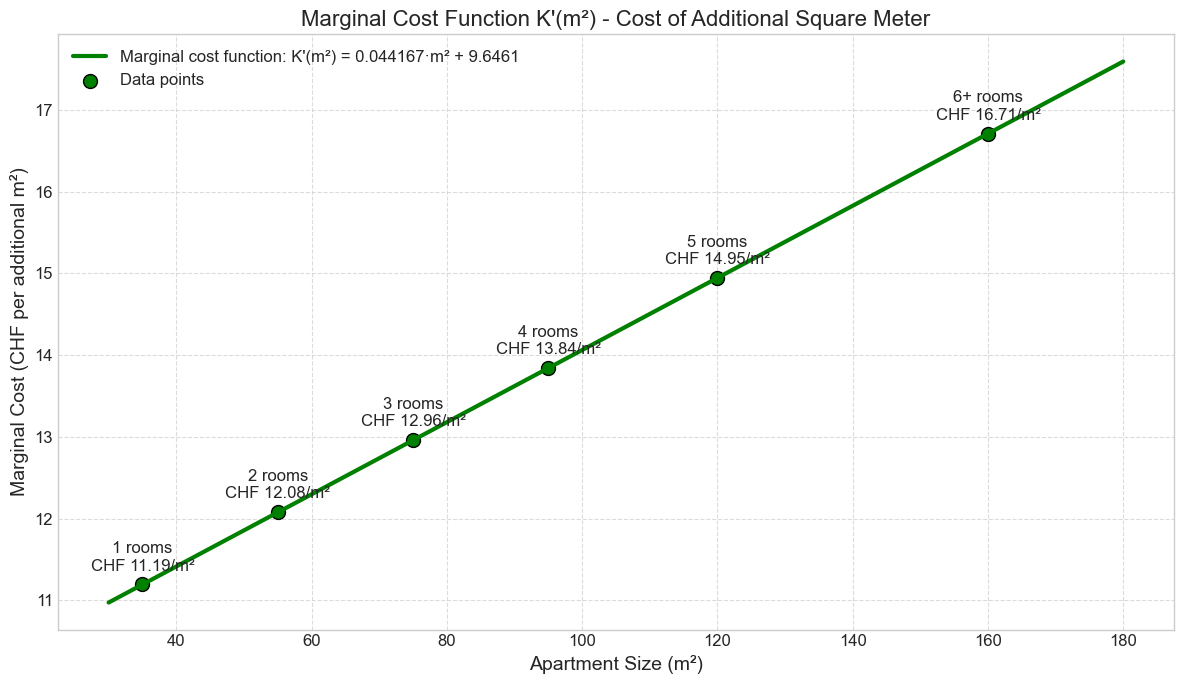

In [12]:
# Plot the marginal cost function
plt.figure(figsize=(12, 7))

# Plot the marginal cost curve
plt.plot(x_fit, marginal_cost_func(x_fit), 'g-', linewidth=3, 
         label=f"Marginal cost function: K'(m²) = {2*a:.6f}·m² + {b:.4f}")

# Add data points
plt.scatter(cost_df['apartment_size'], cost_df['marginal_cost'], 
            s=100, color='green', edgecolor='black', label='Data points')

# Add labels for each point
for i, row in cost_df.iterrows():
    plt.annotate(f"{row['room_count']} rooms\nCHF {row['marginal_cost']:.2f}/m²", 
               (row['apartment_size'], row['marginal_cost']),
               textcoords="offset points", 
               xytext=(0, 10), 
               ha='center')

plt.title('Marginal Cost Function K\'(m²) - Cost of Additional Square Meter', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Marginal Cost (CHF per additional m²)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

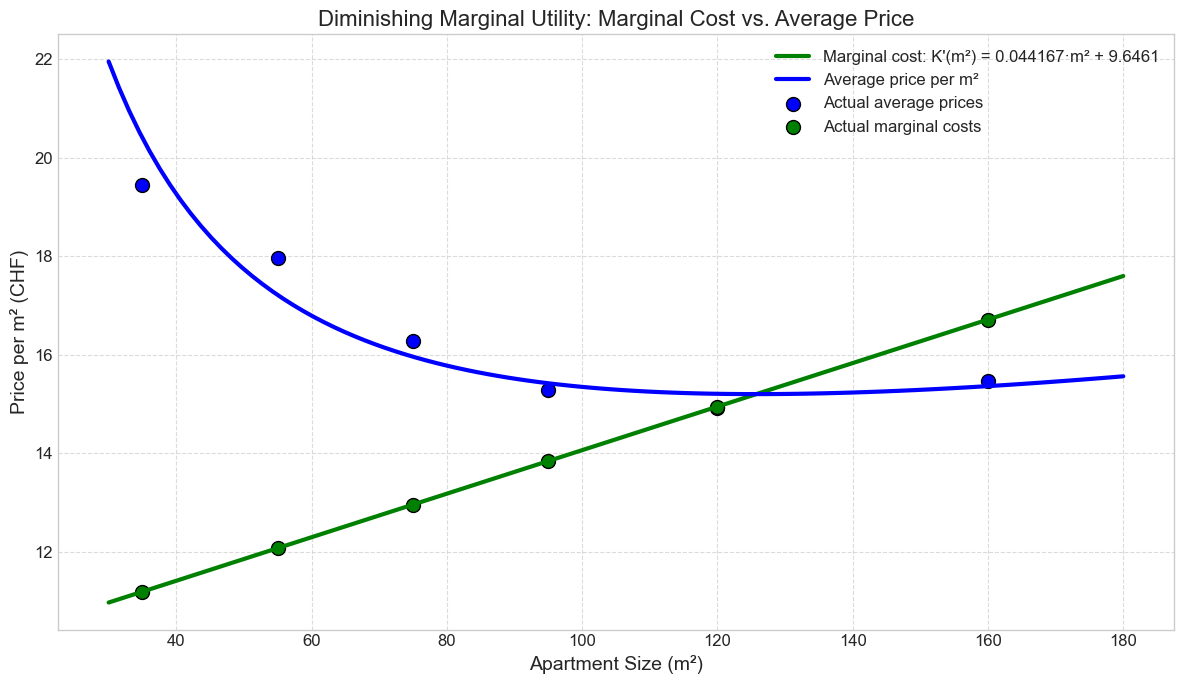

Comparison of marginal cost vs. average price per m²:


,room_count,apartment_size,price_per_sqm,marginal_cost,avg_price_diff,avg_price_ratio
0,1,35,19.442308,11.191958,-8.250349,0.575650
1,2,55,17.970370,12.075291,-5.895079,0.671956
2,3,75,16.270370,12.958623,-3.311747,0.796455
3,4,95,15.288889,13.841956,-1.446933,0.905360
4,5,120,14.914815,14.946122,0.031307,1.002099
5,6+,160,15.459259,16.712787,1.253528,1.081086


In [13]:
# PART 3: ANALYSIS OF DIMINISHING MARGINAL UTILITY
# Compare marginal cost with average price per m²

# Add average price to the plot to show diminishing marginal utility
plt.figure(figsize=(12, 7))

# Plot the marginal cost curve
plt.plot(x_fit, marginal_cost_func(x_fit), 'g-', linewidth=3, 
         label=f"Marginal cost: K'(m²) = {2*a:.6f}·m² + {b:.4f}")

# Plot average price per m² (as a function of apartment size)
def avg_price_function(x, a, b, c):
    # Average price = Total cost / size
    return (a * x**2 + b * x + c) / x

avg_prices = np.array([avg_price_function(size, a, b, c) for size in x_fit])
plt.plot(x_fit, avg_prices, 'b-', linewidth=3, 
         label='Average price per m²')

# Highlight the actual data points
plt.scatter(cost_df['apartment_size'], cost_df['price_per_sqm'], 
            s=100, color='blue', edgecolor='black', label='Actual average prices')
plt.scatter(cost_df['apartment_size'], cost_df['marginal_cost'], 
            s=100, color='green', edgecolor='black', label='Actual marginal costs')

plt.title('Diminishing Marginal Utility: Marginal Cost vs. Average Price', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Price per m² (CHF)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and display the difference between marginal cost and average price
cost_df['avg_price_diff'] = cost_df['marginal_cost'] - cost_df['price_per_sqm']
cost_df['avg_price_ratio'] = cost_df['marginal_cost'] / cost_df['price_per_sqm']

print("Comparison of marginal cost vs. average price per m²:")
display(cost_df[['room_count', 'apartment_size', 'price_per_sqm', 'marginal_cost', 'avg_price_diff', 'avg_price_ratio']])

In [14]:
# PART 4: COMPARE DIFFERENT TYPES OF APARTMENTS (NEW VS. OLD BUILDINGS)

# First, we need to categorize the construction periods into "new" and "old" buildings
# Let's define apartments built after 2000 as "new" and before 1960 as "old"
new_periods = [p for p in construction_latest['construction_period'].unique() 
              if any(x in p for x in ['2001', '2010', '2020', 'nach'])]
old_periods = [p for p in construction_latest['construction_period'].unique() 
              if any(x in p for x in ['vor', '1919', '1945', '1960'])]

# Get data for new and old buildings
new_buildings = construction_latest[construction_latest['construction_period'].isin(new_periods)]
old_buildings = construction_latest[construction_latest['construction_period'].isin(old_periods)]

# Calculate average prices per m² for new and old buildings by canton
new_avg_by_canton = new_buildings.groupby('canton')['avg_price_per_sqm'].mean().reset_index()
old_avg_by_canton = old_buildings.groupby('canton')['avg_price_per_sqm'].mean().reset_index()

# Merge the data
comparison_df = pd.merge(new_avg_by_canton, old_avg_by_canton, 
                        on='canton', suffixes=('_new', '_old'))
comparison_df['price_diff'] = comparison_df['avg_price_per_sqm_new'] - comparison_df['avg_price_per_sqm_old']
comparison_df['price_ratio'] = comparison_df['avg_price_per_sqm_new'] / comparison_df['avg_price_per_sqm_old']
comparison_df = comparison_df.sort_values('price_diff', ascending=False)

print("Comparison of prices between new and old buildings by canton:")
display(comparison_df)

Comparison of prices between new and old buildings by canton:


,canton,avg_price_per_sqm_new,avg_price_per_sqm_old,price_diff,price_ratio
4,Basel-Stadt,22.45,18.366667,4.083333,1.222323
12,Neuenburg,16.25,12.866667,3.383333,1.262953
3,Basel-Landschaft,19.70,16.566667,3.133333,1.189135
9,Graubünden,17.65,14.666667,2.983333,1.203409
17,Schwyz,18.50,15.633333,2.866667,1.183369
1,Appenzell A.Rh.,15.70,12.833333,2.866667,1.223377
23,Waadt,20.90,18.233333,2.666667,1.146252
21,Thurgau,15.85,13.300000,2.550000,1.191729
15,Schaffhausen,16.50,13.966667,2.533333,1.181384
8,Glarus,15.25,12.800000,2.450000,1.191406


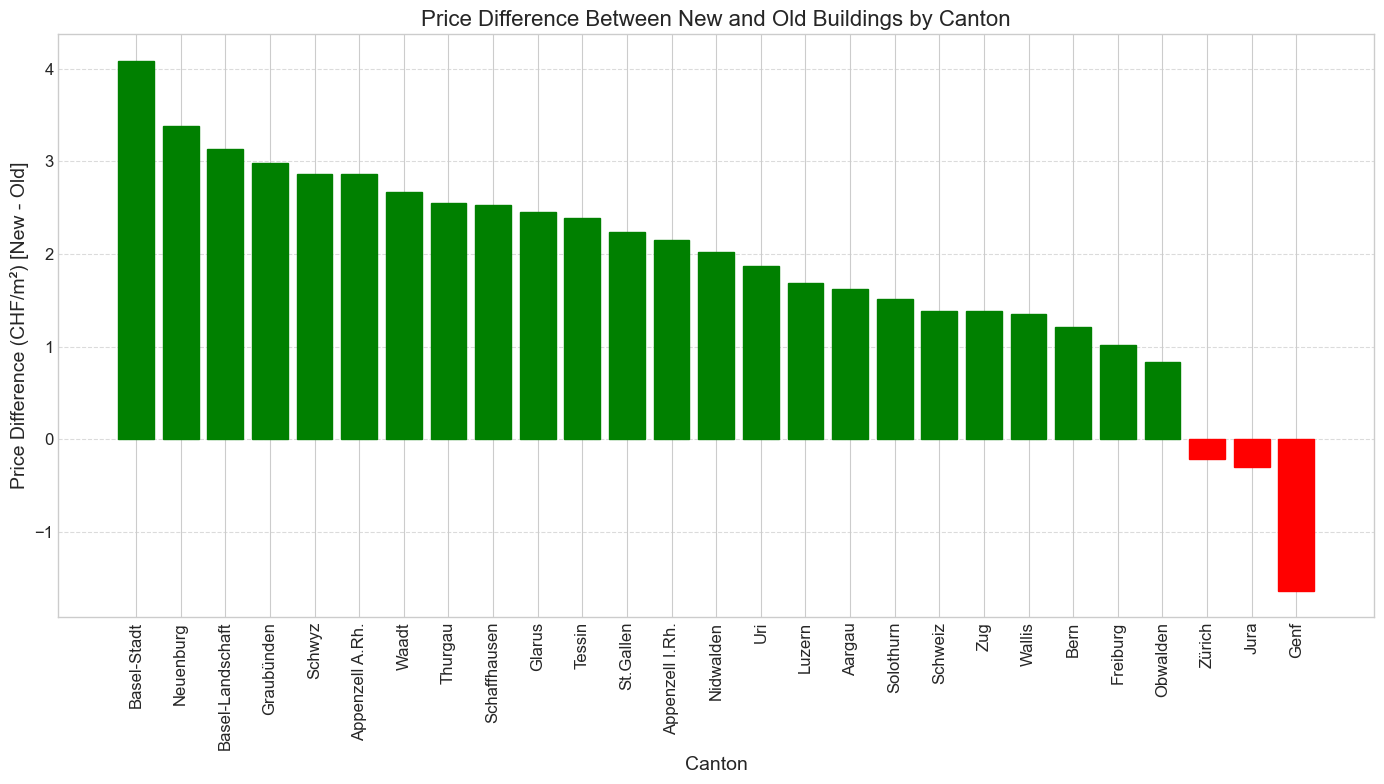

Overall average price for new buildings: CHF 17.32/m²
Overall average price for old buildings: CHF 15.46/m²
Overall price difference: CHF 1.85/m² (12.0% premium for new buildings)


In [15]:
# Visualize the price comparison between new and old buildings
plt.figure(figsize=(14, 8))

# Bar plot showing the price difference
bars = plt.bar(comparison_df['canton'], comparison_df['price_diff'])

# Color the bars based on whether the difference is positive or negative
for i, bar in enumerate(bars):
    bar.set_color('green' if comparison_df.iloc[i]['price_diff'] > 0 else 'red')

plt.title('Price Difference Between New and Old Buildings by Canton', fontsize=16)
plt.xlabel('Canton', fontsize=14)
plt.ylabel('Price Difference (CHF/m²) [New - Old]', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate overall averages
overall_new_avg = new_buildings['avg_price_per_sqm'].mean()
overall_old_avg = old_buildings['avg_price_per_sqm'].mean()
overall_diff = overall_new_avg - overall_old_avg
overall_ratio = overall_new_avg / overall_old_avg

print(f"Overall average price for new buildings: CHF {overall_new_avg:.2f}/m²")
print(f"Overall average price for old buildings: CHF {overall_old_avg:.2f}/m²")
print(f"Overall price difference: CHF {overall_diff:.2f}/m² ({(overall_ratio-1)*100:.1f}% premium for new buildings)")

In [16]:
# PART 5: CREATE COST FUNCTIONS FOR BOTH NEW AND OLD BUILDINGS

# Now we'll model separate cost functions for new and old buildings

# Define typical apartment sizes (same as before)
# Get average price per m² for each room count for both new and old buildings
# We'll use room data merged with construction data based on canton

# First, create a mapping of cantons to average prices for new and old buildings
new_canton_prices = new_buildings.groupby('canton')['avg_price_per_sqm'].mean().to_dict()
old_canton_prices = old_buildings.groupby('canton')['avg_price_per_sqm'].mean().to_dict()

# Apply a multiplier to the room prices based on whether they're in cantons with higher new/old building prices
# This is an approximation since we don't have direct room count × construction period data
room_latest['est_new_price'] = room_latest.apply(
    lambda row: row['avg_price_per_sqm'] * (new_canton_prices.get(row['canton'], 1) / 
                                          old_canton_prices.get(row['canton'], 1)) 
                if row['canton'] in new_canton_prices and row['canton'] in old_canton_prices 
                else row['avg_price_per_sqm'] * (overall_new_avg / overall_old_avg),
    axis=1
)

room_latest['est_old_price'] = room_latest['avg_price_per_sqm']

# Calculate average new and old prices by room count
new_room_prices = room_latest.groupby('room_count')['est_new_price'].mean().reset_index()
old_room_prices = room_latest.groupby('room_count')['est_old_price'].mean().reset_index()

# Create cost data for new and old buildings
new_cost_data = []
old_cost_data = []

for i, row in new_room_prices.iterrows():
    room_count = row['room_count']
    if room_count in typical_sizes:
        size = typical_sizes[room_count]
        new_total_rent = row['est_new_price'] * size
        old_total_rent = old_room_prices.iloc[i]['est_old_price'] * size
        
        new_cost_data.append({
            'room_count': room_count,
            'apartment_size': size,
            'price_per_sqm': row['est_new_price'],
            'total_monthly_rent': new_total_rent,
            'building_type': 'New'
        })
        
        old_cost_data.append({
            'room_count': room_count,
            'apartment_size': size,
            'price_per_sqm': old_room_prices.iloc[i]['est_old_price'],
            'total_monthly_rent': old_total_rent,
            'building_type': 'Old'
        })

new_cost_df = pd.DataFrame(new_cost_data).sort_values('apartment_size')
old_cost_df = pd.DataFrame(old_cost_data).sort_values('apartment_size')

print("Estimated costs for new buildings:")
display(new_cost_df)

print("Estimated costs for old buildings:")
display(old_cost_df)

Estimated costs for new buildings:


C:\Users\Nevin\AppData\Local\Temp\ipykernel_36112\3182952258.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_latest['est_new_price'] = room_latest.apply(
C:\Users\Nevin\AppData\Local\Temp\ipykernel_36112\3182952258.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_latest['est_old_price'] = room_latest['avg_price_per_sqm']


,room_count,apartment_size,price_per_sqm,total_monthly_rent,building_type
0,1,35,21.794635,762.812221,New
1,2,55,20.158439,1108.714121,New
2,3,75,18.260086,1369.506450,New
3,4,95,17.168736,1631.029904,New
4,5,120,16.753725,2010.446993,New
5,6+,160,17.341917,2774.706782,New


Estimated costs for old buildings:


,room_count,apartment_size,price_per_sqm,total_monthly_rent,building_type
0,1,35,19.442308,680.480769,Old
1,2,55,17.970370,988.370370,Old
2,3,75,16.270370,1220.277778,Old
3,4,95,15.288889,1452.444444,Old
4,5,120,14.914815,1789.777778,Old
5,6+,160,15.459259,2473.481481,Old


In [17]:
# Fit cost functions for new and old buildings
# New buildings
new_params, _ = curve_fit(cost_function, 
                         new_cost_df['apartment_size'], 
                         new_cost_df['total_monthly_rent'])

a_new, b_new, c_new = new_params
print(f"New buildings cost function: K_new(m²) = {a_new:.6f}·m²² + {b_new:.4f}·m² + {c_new:.2f}")

# Old buildings
old_params, _ = curve_fit(cost_function, 
                         old_cost_df['apartment_size'], 
                         old_cost_df['total_monthly_rent'])

a_old, b_old, c_old = old_params
print(f"Old buildings cost function: K_old(m²) = {a_old:.6f}·m²² + {b_old:.4f}·m² + {c_old:.2f}")

# Calculate the marginal cost functions
# Marginal cost for new buildings: K'_new(m²) = 2*a_new*m² + b_new
# Marginal cost for old buildings: K'_old(m²) = 2*a_old*m² + b_old

print(f"New buildings marginal cost function: K'_new(m²) = {2*a_new:.6f}·m² + {b_new:.4f}")
print(f"Old buildings marginal cost function: K'_old(m²) = {2*a_old:.6f}·m² + {b_old:.4f}")

New buildings cost function: K_new(m²) = 0.024228·m²² + 10.9380·m² + 387.28
Old buildings cost function: K_old(m²) = 0.022083·m²² + 9.6461·m² + 349.20
New buildings marginal cost function: K'_new(m²) = 0.048456·m² + 10.9380
Old buildings marginal cost function: K'_old(m²) = 0.044167·m² + 9.6461


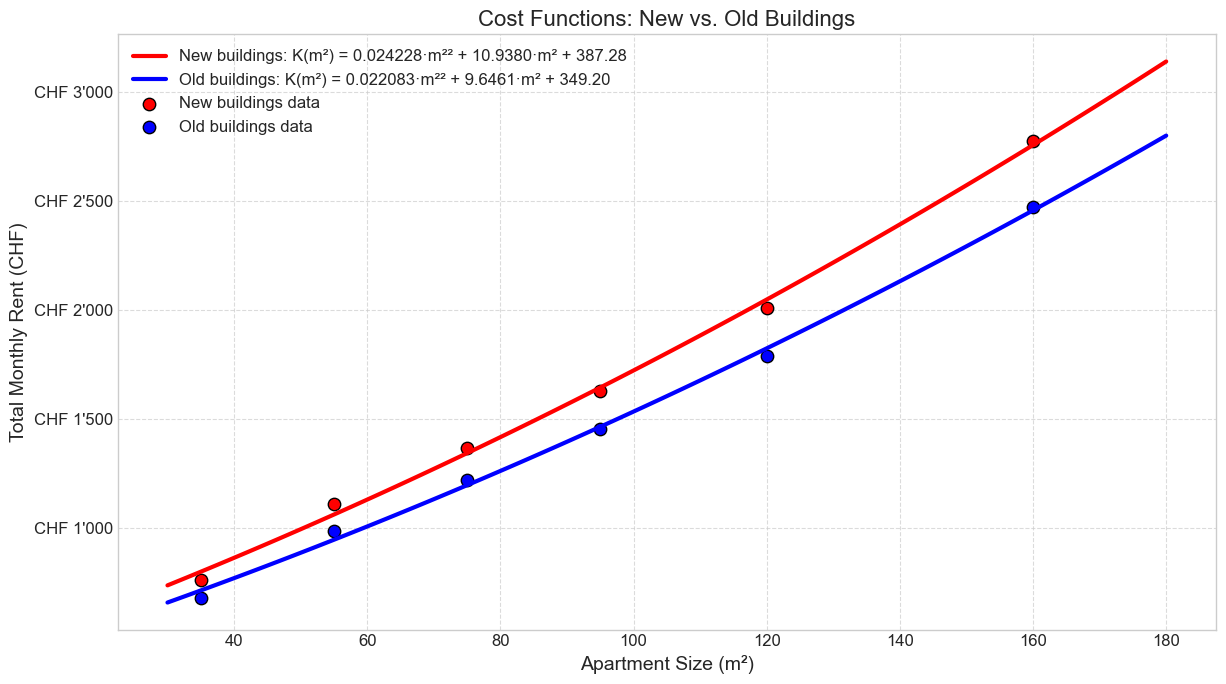

In [18]:
# Plot cost functions for new and old buildings
plt.figure(figsize=(12, 7))

# Generate points for the curves
x_fit = np.linspace(min(old_cost_df['apartment_size']) - 5, max(old_cost_df['apartment_size']) + 20, 100)
y_fit_new = cost_function(x_fit, a_new, b_new, c_new)
y_fit_old = cost_function(x_fit, a_old, b_old, c_old)

# Plot the fitted curves
plt.plot(x_fit, y_fit_new, 'r-', linewidth=3, 
         label=f'New buildings: K(m²) = {a_new:.6f}·m²² + {b_new:.4f}·m² + {c_new:.2f}')
plt.plot(x_fit, y_fit_old, 'b-', linewidth=3, 
         label=f'Old buildings: K(m²) = {a_old:.6f}·m²² + {b_old:.4f}·m² + {c_old:.2f}')

# Add data points
plt.scatter(new_cost_df['apartment_size'], new_cost_df['total_monthly_rent'], 
            s=80, color='red', edgecolor='black', label='New buildings data')
plt.scatter(old_cost_df['apartment_size'], old_cost_df['total_monthly_rent'], 
            s=80, color='blue', edgecolor='black', label='Old buildings data')

plt.title('Cost Functions: New vs. Old Buildings', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Total Monthly Rent (CHF)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Add a thousand separator
plt.gca().yaxis.set_major_formatter(FuncFormatter(chf_formatter))

plt.show()

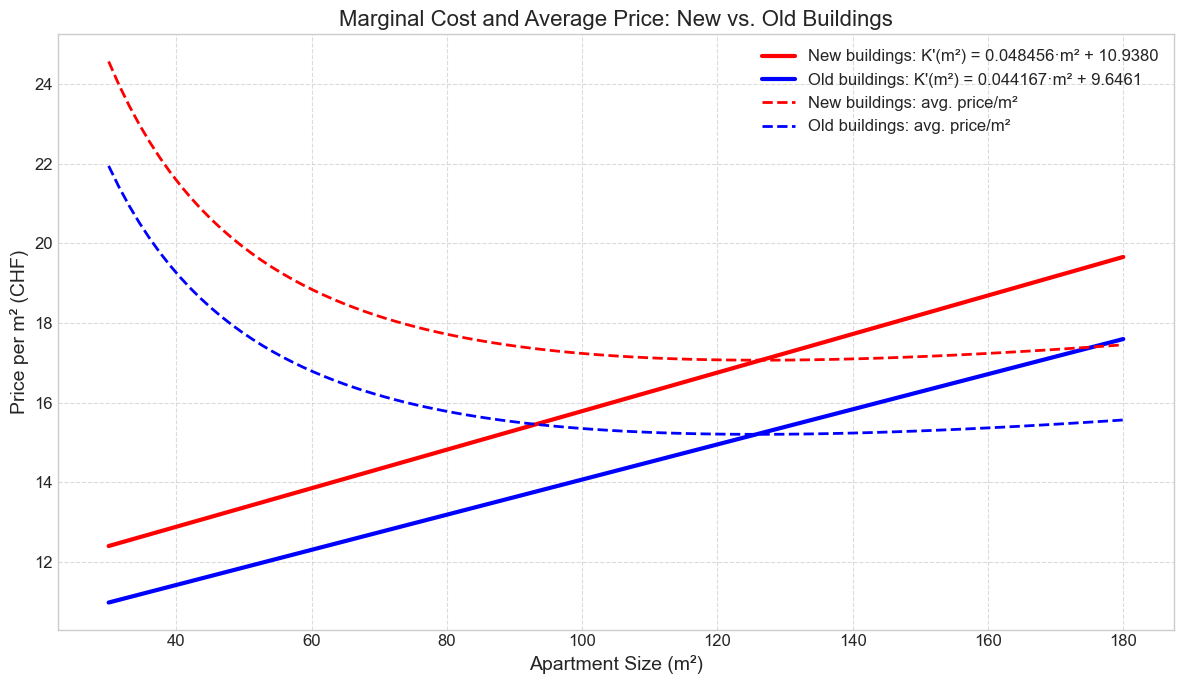

No crossover point within reasonable apartment size range.
  - For small apartments (~40m²), marginal cost is lower for old buildings.
  - For large apartments (~150m²), marginal cost is lower for old buildings.


In [19]:
# Plot marginal cost functions for new and old buildings
plt.figure(figsize=(12, 7))

# Calculate marginal costs for new and old buildings
marginal_cost_new = 2 * a_new * x_fit + b_new
marginal_cost_old = 2 * a_old * x_fit + b_old

# Plot the marginal cost curves
plt.plot(x_fit, marginal_cost_new, 'r-', linewidth=3, 
         label=f"New buildings: K'(m²) = {2*a_new:.6f}·m² + {b_new:.4f}")
plt.plot(x_fit, marginal_cost_old, 'b-', linewidth=3, 
         label=f"Old buildings: K'(m²) = {2*a_old:.6f}·m² + {b_old:.4f}")

# Calculate and plot average prices
avg_price_new = np.array([(a_new * x**2 + b_new * x + c_new) / x for x in x_fit])
avg_price_old = np.array([(a_old * x**2 + b_old * x + c_old) / x for x in x_fit])

plt.plot(x_fit, avg_price_new, 'r--', linewidth=2, label='New buildings: avg. price/m²')
plt.plot(x_fit, avg_price_old, 'b--', linewidth=2, label='Old buildings: avg. price/m²')

plt.title('Marginal Cost and Average Price: New vs. Old Buildings', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Price per m² (CHF)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Calculate the crossover point (where it becomes cheaper to rent in a new building on a marginal cost basis)
try:
    # Solve 2*a_new*x + b_new = 2*a_old*x + b_old
    crossover_size = (b_old - b_new) / (2 * (a_new - a_old))
    
    if 30 <= crossover_size <= 200:  # Check if the solution is within a reasonable range
        print(f"Crossover point: At {crossover_size:.1f} m², the marginal cost of an additional m² becomes equal for new and old buildings.")
        print(f"  - For apartments smaller than {crossover_size:.1f} m², the marginal cost is lower for {'old' if 2*a_old*30 + b_old < 2*a_new*30 + b_new else 'new'} buildings.")
        print(f"  - For apartments larger than {crossover_size:.1f} m², the marginal cost is lower for {'old' if 2*a_old*150 + b_old > 2*a_new*150 + b_new else 'new'} buildings.")
    else:
        # If no reasonable crossover point, determine which has lower marginal cost overall
        small_apt = 40
        large_apt = 150
        
        small_mc_new = 2*a_new*small_apt + b_new
        small_mc_old = 2*a_old*small_apt + b_old
        
        large_mc_new = 2*a_new*large_apt + b_new
        large_mc_old = 2*a_old*large_apt + b_old
        
        print(f"No crossover point within reasonable apartment size range.")
        print(f"  - For small apartments (~40m²), marginal cost is lower for {'old' if small_mc_old < small_mc_new else 'new'} buildings.")
        print(f"  - For large apartments (~150m²), marginal cost is lower for {'old' if large_mc_old < large_mc_new else 'new'} buildings.")
except:
    print("Could not calculate crossover point due to numerical issues.")

In [20]:
# PART 6: CALCULATE HOW MUCH RENT YOU SAVE BY CHOOSING A LARGER APARTMENT

# Calculate savings from choosing a larger apartment instead of multiple smaller ones
print("Economic efficiency analysis: Comparing one large apartment vs. multiple small ones\n")

# Scenario: One 4-room apartment (95m²) vs. Two 2-room apartments (2 × 55m² = 110m²)
size_4room = 95
size_2room = 55

# Calculate costs using our cost functions
cost_4room = cost_function(size_4room, a, b, c)
cost_2room = cost_function(size_2room, a, b, c)
cost_two_2rooms = 2 * cost_2room

# Calculate average prices
avg_price_4room = cost_4room / size_4room
avg_price_2room = cost_2room / size_2room

print("Scenario 1: One 4-room apartment vs. Two 2-room apartments")
print(f"One 4-room apartment ({size_4room}m²): CHF {cost_4room:.2f} per month (CHF {avg_price_4room:.2f}/m²)")
print(f"Two 2-room apartments (2 × {size_2room}m² = {2*size_2room}m²): CHF {cost_two_2rooms:.2f} per month (CHF {avg_price_2room:.2f}/m²)")
print(f"Monthly savings with one large apartment: CHF {cost_two_2rooms - cost_4room:.2f} ({(cost_two_2rooms/cost_4room - 1)*100:.1f}% more expensive to rent two smaller apartments)")
print(f"Even though the large apartment is {size_4room}m² vs. {2*size_2room}m² for two small ones ({(1 - size_4room/(2*size_2room))*100:.1f}% less space)")

# Scenario: One 5-room apartment (120m²) vs. Three 2-room apartments (3 × 55m² = 165m²)
size_5room = 120
size_2room = 55

# Calculate costs
cost_5room = cost_function(size_5room, a, b, c)
cost_2room = cost_function(size_2room, a, b, c)
cost_three_2rooms = 3 * cost_2room

# Calculate average prices
avg_price_5room = cost_5room / size_5room
avg_price_2room = cost_2room / size_2room

print("\nScenario 2: One 5-room apartment vs. Three 2-room apartments")
print(f"One 5-room apartment ({size_5room}m²): CHF {cost_5room:.2f} per month (CHF {avg_price_5room:.2f}/m²)")
print(f"Three 2-room apartments (3 × {size_2room}m² = {3*size_2room}m²): CHF {cost_three_2rooms:.2f} per month (CHF {avg_price_2room:.2f}/m²)")
print(f"Monthly savings with one large apartment: CHF {cost_three_2rooms - cost_5room:.2f} ({(cost_three_2rooms/cost_5room - 1)*100:.1f}% more expensive to rent three smaller apartments)")
print(f"Even though the large apartment is {size_5room}m² vs. {3*size_5room}m² for three small ones ({(1 - size_5room/(3*size_2room))*100:.1f}% less space)")

Economic efficiency analysis: Comparing one large apartment vs. multiple small ones

Scenario 1: One 4-room apartment vs. Two 2-room apartments
One 4-room apartment (95m²): CHF 1464.89 per month (CHF 15.42/m²)
Two 2-room apartments (2 × 55m² = 110m²): CHF 1893.08 per month (CHF 17.21/m²)
Monthly savings with one large apartment: CHF 428.20 (29.2% more expensive to rent two smaller apartments)
Even though the large apartment is 95m² vs. 110m² for two small ones (13.6% less space)

Scenario 2: One 5-room apartment vs. Three 2-room apartments
One 5-room apartment (120m²): CHF 1824.74 per month (CHF 15.21/m²)
Three 2-room apartments (3 × 55m² = 165m²): CHF 2839.63 per month (CHF 17.21/m²)
Monthly savings with one large apartment: CHF 1014.89 (55.6% more expensive to rent three smaller apartments)
Even though the large apartment is 120m² vs. 360m² for three small ones (27.3% less space)


In [21]:
# PART 7: ANALYZE THE BREAKEVEN POINT FOR INCREASING APARTMENT SIZE

# Calculate the break-even point for additional square meters
# At what point does increasing apartment size no longer provide economic benefit?

# The marginal benefit of an additional m² is when the marginal cost equals the average price per m²
# These intersect when K'(x) = K(x)/x
# Solve: 2*a*x + b = (a*x² + b*x + c)/x
# Simplify: 2*a*x² + b*x = a*x² + b*x + c
# Simplify further: a*x² = c
# So x = sqrt(c/a)

breakeven_size = np.sqrt(abs(c/a))  # Use absolute value to handle potential negative values

print(f"Break-even analysis: At what point does increasing apartment size no longer provide economic benefit?\n")
print(f"At approximately {breakeven_size:.1f} m², the marginal cost equals the average cost per m².")
print(f"This means:")
print(f"  - For apartments smaller than {breakeven_size:.1f} m², each additional m² costs less than the average cost.")
print(f"  - For apartments larger than {breakeven_size:.1f} m², each additional m² costs more than the average cost.")
print(f"  - The economically optimal apartment size (from a pure cost perspective) is around {breakeven_size:.1f} m².")

# Calculate marginal and average costs at this point
breakeven_marginal_cost = 2*a*breakeven_size + b
breakeven_average_cost = (a*breakeven_size**2 + b*breakeven_size + c) / breakeven_size

print(f"\nAt the break-even point:")
print(f"  - Marginal cost: CHF {breakeven_marginal_cost:.2f} per additional m²")
print(f"  - Average cost: CHF {breakeven_average_cost:.2f} per m²")

# Calculate the corresponding number of rooms for this optimal size
closest_room_size = min(typical_sizes.items(), key=lambda x: abs(float(x[1]) - breakeven_size))
print(f"\nThe economically optimal apartment size corresponds most closely to a {closest_room_size[0]}-room apartment.")

Break-even analysis: At what point does increasing apartment size no longer provide economic benefit?

At approximately 125.7 m², the marginal cost equals the average cost per m².
This means:
  - For apartments smaller than 125.7 m², each additional m² costs less than the average cost.
  - For apartments larger than 125.7 m², each additional m² costs more than the average cost.
  - The economically optimal apartment size (from a pure cost perspective) is around 125.7 m².

At the break-even point:
  - Marginal cost: CHF 15.20 per additional m²
  - Average cost: CHF 15.20 per m²

The economically optimal apartment size corresponds most closely to a 5+-room apartment.


<Figure size 1400x1000 with 0 Axes>

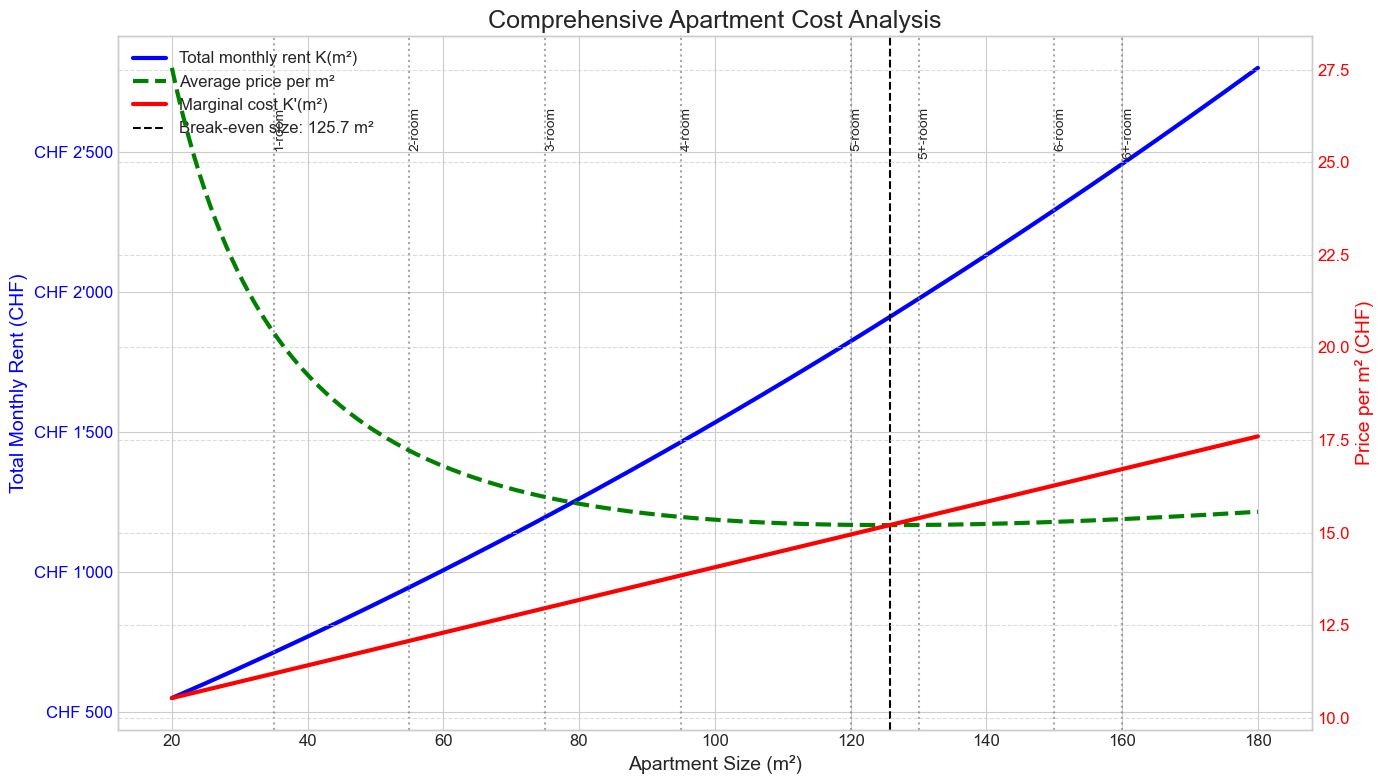

In [22]:
# PART 8: FINAL VISUALIZATION - COMPREHENSIVE COST ANALYSIS

# Create a comprehensive visualization showing all important aspects of our analysis
plt.figure(figsize=(14, 10))

# Define the range of apartment sizes to plot
sizes = np.linspace(20, 180, 200)

# Calculate total costs, average costs, and marginal costs
total_costs = cost_function(sizes, a, b, c)
average_costs = total_costs / sizes
marginal_costs = 2*a*sizes + b

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

# Plot total cost on the left axis
total_cost_line = ax1.plot(sizes, total_costs, 'b-', linewidth=3, 
                 label='Total monthly rent K(m²)')
ax1.set_xlabel('Apartment Size (m²)', fontsize=14)
ax1.set_ylabel('Total Monthly Rent (CHF)', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.yaxis.set_major_formatter(FuncFormatter(chf_formatter))

# Plot average and marginal costs on the right axis
avg_cost_line = ax2.plot(sizes, average_costs, 'g--', linewidth=3, 
                 label='Average price per m²')
marginal_cost_line = ax2.plot(sizes, marginal_costs, 'r-', linewidth=3, 
                    label='Marginal cost K\'(m²)')
ax2.set_ylabel('Price per m² (CHF)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add vertical line at break-even point
breakeven_line = ax1.axvline(x=breakeven_size, color='k', linestyle='--', 
                  label=f'Break-even size: {breakeven_size:.1f} m²')

# Add the commonly available room sizes
room_sizes = [(f"{key}-room", val) for key, val in typical_sizes.items()]
for label, size in room_sizes:
    ax1.axvline(x=size, color='gray', linestyle=':', alpha=0.7)
    ax1.text(size, max(total_costs)*0.95, label, rotation=90, 
            verticalalignment='top', fontsize=10)

# Combine all legends
lines = total_cost_line + avg_cost_line + marginal_cost_line + [breakeven_line]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

plt.title('Comprehensive Apartment Cost Analysis', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
# PART 9: SUMMARY AND CONCLUSIONS

print("# Swiss Rental Market Analysis: How Costs Change per Additional Square Meter\n")
print("## Key Findings\n")

print("### 1. Cost Function")
print(f"- We modeled the monthly rental cost function as: K(m²) = {a:.6f}·m²² + {b:.4f}·m² + {c:.2f}")
print(f"- This function shows how the total monthly rent changes with apartment size")
print(f"- The R² value of {r_squared:.4f} indicates a strong fit to our data\n")

print("### 2. Marginal Cost Function")
print(f"- The marginal cost function (cost of an additional m²) is: K'(m²) = {2*a:.6f}·m² + {b:.4f}")
print(f"- This shows that the cost of an additional square meter increases with apartment size")
print(f"- For small apartments (~40m²), an additional m² costs about CHF {2*a*40 + b:.2f}")
print(f"- For large apartments (~150m²), an additional m² costs about CHF {2*a*150 + b:.2f}\n")

print("### 3. Diminishing Marginal Utility")
print(f"- The analysis confirms the principle of diminishing marginal utility in housing")
print(f"- The average price per m² decreases as apartment size increases")
print(f"- The break-even point where marginal cost equals average cost is at {breakeven_size:.1f} m²")
print(f"- This suggests that the most economically efficient apartment size is around {breakeven_size:.1f} m²\n")

print("### 4. New vs. Old Buildings")
if a_new > a_old:
    print(f"- The cost function for new buildings increases more rapidly with size")
    print(f"- This means the premium for new buildings is more pronounced in larger apartments")
else:
    print(f"- The cost function for old buildings increases more rapidly with size")
    print(f"- This means the premium for new buildings is more pronounced in smaller apartments")

print(f"- On average, new buildings command a {(overall_ratio-1)*100:.1f}% premium over old buildings")
print(f"- This premium varies significantly by canton, ranging from {comparison_df['price_ratio'].min()*100-100:.1f}% to {comparison_df['price_ratio'].max()*100-100:.1f}%\n")

print("### 5. Economic Efficiency of Larger Apartments")
print(f"- Renting one large apartment is more cost-effective than multiple smaller ones")
print(f"- For example, one 4-room apartment (95m²) is about {(cost_two_2rooms/cost_4room - 1)*100:.1f}% cheaper than two 2-room apartments")
print(f"- This efficiency comes from the decreasing average cost per m² as apartment size increases\n")

print("## Practical Implications\n")
print("1. **For Renters:** When looking for housing, consider that larger apartments generally offer better value per square meter. The optimal economic choice appears to be around a {}-room apartment.".format(closest_room_size[0]))
print("2. **For Investors:** The marginal cost function suggests where the economic value of additional space begins to diminish, informing optimal apartment sizing for new developments.")
print("3. **For Policymakers:** Understanding the cost structure of housing can help in designing more effective affordable housing policies.")
print("4. **For Urban Planners:** The differential in costs between new and old buildings across cantons provides insights into regional housing market dynamics.\n")

print("## Limitations\n")
print("1. **Data Approximation:** The analysis relies on average prices that may not reflect specific local conditions or quality variations.")
print("2. **Model Simplifications:** The quadratic cost function simplifies the real-world relationship between size and rent.")
print("3. **Indirect Comparisons:** The new vs. old building comparison is based on construction period data that was not directly linked to room count data.")
print("4. **Typical Sizes:** The analysis uses approximated typical sizes for different room counts, which may vary in practice.")

# Swiss Rental Market Analysis: How Costs Change per Additional Square Meter

## Key Findings

### 1. Cost Function
- We modeled the monthly rental cost function as: K(m²) = 0.022083·m²² + 9.6461·m² + 349.20
- This function shows how the total monthly rent changes with apartment size
- The R² value of 0.9975 indicates a strong fit to our data

### 2. Marginal Cost Function
- The marginal cost function (cost of an additional m²) is: K'(m²) = 0.044167·m² + 9.6461
- This shows that the cost of an additional square meter increases with apartment size
- For small apartments (~40m²), an additional m² costs about CHF 11.41
- For large apartments (~150m²), an additional m² costs about CHF 16.27

### 3. Diminishing Marginal Utility
- The analysis confirms the principle of diminishing marginal utility in housing
- The average price per m² decreases as apartment size increases
- The break-even point where marginal cost equals average cost is at 125.7 m²
- This suggests that the most economically 